# don't forget to hop into the conda3 virtual environment — source activate base

To Dos:
<ul>
    <li> load glucose + fasting status</li>
    <li> make sure to add smoking to the risk factor models</li>
    <li> physical activity...is ther ea quesiton that aligns with "have you exercisedin the last two weeks?</li>
    <li> waist circumference</li>
    <li> creatinine/GFR</li>
    <li> a. fib </li>
    <li> build out the nhanes file loader method below into something prettier</li>
</ul>

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os

pd.set_option('display.max_columns', None)

In [2]:
baseDir = "/Users/burke/Documents/research/bpCog/nhanes/sourceData/"
os.chdir(baseDir)

### Function to download NHANES files for specific variables

In [3]:
import wget
def downloadYear(year, stem):
    plusOne = year + 1
    dirName = "nhanesRawData/" + str(year) + "-" + str(plusOne)
    os.chdir(dirName)
    url = "https://wwwn.cdc.gov/Nchs/Nhanes/" + str(year) + "-" + str(plusOne) + "/" + stem + ".XPT"
    fileName = wget.download(url, stem + ".XPT")  
    # Overwrite file if already exists
    if os.path.exists(fileName):
        shutil.move(fileName,stem + ".XPT")
    os.chdir(baseDir)
    return pd.read_sas(os.path.join(dirName, stem + '.XPT'))
   

In [4]:
import wget
import os.path
import shutil
     
glucoseFileStems = ['LAB10AM', 'L10_2_B','L10AM_C', 'GLU_D', 'GLU_E', 'GLU_F', 'GLU_G', 'GLU_H', 'GLU_I' ]

stemIndex = 0  
for year in range(1999,2016,2):
    downloadYear(year, glucoseFileStems[stemIndex])
    stemIndex += 1
    
    
paqFileStems = ['PAQ', 'PAQ_B','PAQ_C', 'PAQ_D', 'PAQ_E', 'PAQ_F', 'PAQ_G', 'PAQ_H', 'PAQ_I' ]


stemIndex = 0
for year in range(1999,2016,2):
    downloadYear(year, paqFileStems[stemIndex])
    stemIndex += 1

rxFileStems = ['RXQ_RX', 'RXQ_RX_B','RXQ_RX_C', 'RXQ_RX_D', 'RXQ_RX_E', 'RXQ_RX_F', 'RXQ_RX_G', 'RXQ_RX_H', 'RXQ_RX_I' ]
stemIndex = 0
for year in range(1999,2016,2):
    downloadYear(year, rxFileStems[stemIndex])
    stemIndex += 1
    
alcFileStems = ['ALQ', 'ALQ_B','ALQ_C', 'ALQ_D', 'ALQ_E', 'ALQ_F', 'ALQ_G', 'ALQ_H', 'ALQ_I' ]
stemIndex = 0
for year in range(1999,2016,2):
    downloadYear(year, alcFileStems[stemIndex])
    stemIndex += 1


In [5]:
# level one gets us to cardiovascular meds...these are the level 2 value-counts
drugDatafile = downloadYear(1999, 'RXQ_DRUG')
drugDatafile['antiHypertensive'] = 0
drugDatafile['statin'] = 0
drugDatafile['otherLipidLowering'] = 0
drugDatafile.loc[((drugDatafile.RXDDCI1A==40) & (drugDatafile.RXDDCI1B.isin([42, 43, 44,47,48, 49,53,55,56]))), 'antiHypertensive'] = 1
drugDatafile.loc[((drugDatafile.RXDDCI1A==358) & (drugDatafile.RXDDCI1B == 19) & (drugDatafile.RXDDCI1C==173)), 'statin'] = 1
drugDatafile.loc[((drugDatafile.RXDDCI1A==358) & (drugDatafile.RXDDCI1B == 19) & (drugDatafile.RXDDCI1C.isin([174,241,252,316,317]))), 'otherLipidLowering'] = 1

### Load All NHANES Data Files and append into a single dataset



In [6]:
''' iterate through the root directory which has subdiretxories (with year names) for each annual collection of 
raw NHANES data files '''

root = next(os.walk("nhanesRawData"))[0]
yearDirs = next(os.walk("nhanesRawData"))[1]
yearDirsWithRoot = [root + os.sep + year for year in yearDirs]


# loads the files from a year — starts with the demographics files and then merges in all of the other subfiles in the directory

def loadYear(dir):
    demographics = getDemographics(dir)
    otherFiles = next(os.walk(dir))[2]
    otherFiles.remove(demographics)
    
    demoSAS = pd.read_sas(dir + os.sep + demographics)
    for other in otherFiles:
        if other[-3:] == "csv":
            otherSAS = pd.read_csv(dir + os.sep + other)
            demoSAS = demoSAS.merge(otherSAS, how='left', on=['SEQN'])
        elif other.startswith("RXQ"):
            continue
        elif other[-3:].lower() == "xpt":
            print(other)
            otherSAS = pd.read_sas(dir + os.sep + other)
            demoSAS = demoSAS.merge(otherSAS, how='left', on=['SEQN'])
    year = dir[dir.find(os.sep)+1:dir.find("-")]
    demoSAS['year'] = year
    
    # left off here — need to get date of death into this by pulling it from the file year in teh loop
    columnNameMappings = {"RIDAGEYR" : "age", "RIAGENDR" :  "gender",  "RIDRETH1" : "raceEthnicity",
                          "BPXSY1" : "sbp1", "BPXSY2" : "sbp2", "BPXSY3" : "sbp3", "BPXSY4" : "sbp4", "BPXDI1" : "dbp1",
                        "BPXDI2": "dbp2", "BPXDI3" : "dbp3", "BPXDI4" : "dbp4", "LBXGH" : "a1c", "LBDHDD" : "hdl",
                        "LBXTC" : "tot_chol", "SMQ040" : "currentSmoker", "SMQ020" : "quantitySmoked","BMXWT" : "weight",
                          "BMXBMI" : "bmi", "BMXWAIST" : "waist", "LBDLDL" : "ldl", "LBXTR" : "trig",  
                          "DMDYRSUS" : "timeInUS", "MORTSTAT" : "diedBy2015", "UCOD_LEA" : "ucod", 
                         "MCQ160E" :"selfReportMI", "MCQ180E" : "selfReportMIAge", 
                            "MCQ160F" : "selfReportStroke", "MCQ180F" : "selfReportStrokeAge", 
                          "PERMTH_I" : "monthsToDeath", "PERMTH_E" : "monthsToDeath2", "DMDEDUC2" : 'education',
                         'antiHypertensive' : 'antiHypertensive', 'statin' : 'statin', 'otherLipidLowering' : 'otherLipidLowering',
                         'PAQ605' : 'vigorousWork', 'PAQ620' : 'moderateWork', 'PAQ635' : 'walkBicyle', 
                         'PAQ650' : 'vigorousRecreation', 'PAQ665' : 'moderateRecreation',
                         'PAD020' : 'walkBikeOld', 'PAD200' : 'vigorousOld', 'PAD320' : 'moderateOld',
                         'ALQ130' : 'alcoholDrinksPerDay', 'ALQ100' : 'alcoholLastYear',
                         'ALQ110' : 'alcoholLifetime'}
    
    alternateNames = {'LBXTC' : ['LBXTC_x' ], 'LBDHDD' : ['LBDHDL','LBXHDD', 'LBDHDL_x']}
    
    print (year)
    demoSAS.to_csv(str(year + "Before.csv"))
    # we have a couple variable names that get remapped to differnet names...this will remap them all to consistent names
    for key in alternateNames.keys():
        if key not in demoSAS:
            print(str(key) + " is missing from year: " + str(year))
            for value in alternateNames[key]:
                print ("checking: " + value)
                if value in demoSAS:
                    print ("rename: " + value + " to key: " + key)
                    demoSAS.rename(columns={value: key}, inplace=True)

    demoSAS.to_csv(str(year + "InBetween.csv"))

    
    columnsToKeep = list(columnNameMappings.keys())
    columnsToKeep.extend(["SEQN", "WTINT2YR", "WTMEC2YR", "SDMVPSU", "SDMVSTRA", "year"])
    
    # some of the factors that we car eabout are missing in given years...add them and make them null here.
    for value in columnsToKeep:
        if value not in demoSAS:
            demoSAS[value] = np.nan
    
    demoSAS = demoSAS[columnsToKeep]
    demoSAS.rename(columns=columnNameMappings, inplace=True)
    demoSAS.to_csv(str(year) + ".csv")
    
    return demoSAS

def getDemographics(dir):
    files = next(os.walk(dir))[2]
    for file in files:
        if file.startswith("DEMO"):
            return file
    raise Exception("Unable to find demographics file in directory: " + dir)
        
    
# the med files are going to be our exception — for all of the other files, we just need to get a single row per person
# for meds, there are multiple rows per person...so, we'll build a summary file that extracts the med fieds that we care 
# about into a summary file with one line per person
def convertMedsToMedSummaryFiles(dir):
    allFiles = next(os.walk(dir))[2]
    for file in allFiles:
        if file.startswith('RXQ_RX'):
            medsFile = pd.read_sas(os.path.join(dir, file))
            summary = medsFile.merge(drugDatafile, on='RXDDRGID').groupby('SEQN')[['SEQN', 'antiHypertensive', 'statin', 'otherLipidLowering']].sum()
            summary.to_csv(os.path.join(dir, "medSummary.csv"))
    
[convertMedsToMedSummaryFiles(x) for x in yearDirsWithRoot]
yearDataFrames = [loadYear(x) for x in yearDirsWithRoot]
combined = pd.concat(yearDataFrames, sort=True)

combined['anyPhysicalActivity'] = 0
combined.loc[(combined.vigorousWork==1) | (combined.moderateWork==1) | (combined.walkBicyle==1) | (combined.vigorousRecreation==1) | (combined.moderateRecreation==1),'anyPhysicalActivity'] = 1
combined.loc[(combined.walkBikeOld==1) | (combined.vigorousOld==1) | (combined.moderateOld==1),'anyPhysicalActivity'] = 1
combined.drop(labels=['vigorousWork', 'moderateWork', 'walkBicyle', 'vigorousRecreation', 'moderateRecreation', 'walkBikeOld', 'vigorousOld', 'moderateOld'], axis=1, inplace=True)
combined.education.replace(to_replace=[7,9], value=np.nan, inplace=True)


# combine the two smoking status variables into a variable that fits into ASCVD
def generateSmokingStatus(x):
    if np.isclose(x.currentSmoker, 1, 0.0001) or np.isclose(x.currentSmoker, 2, 0.0001):
        return "2"
    elif np.isclose(x.quantitySmoked, 1, 0.0001):
        return "1"
    else:
        return "0"
    
smokingStatusValues = [generateSmokingStatus(x) for _,x in combined.iterrows()]
combined = combined.assign(smokingStatus=pd.Series(data=smokingStatusValues, index=combined.index, dtype="category"))
combined.drop(labels=["currentSmoker", "quantitySmoked"],axis=1, inplace=True)
combined.raceEthnicity = combined.raceEthnicity.astype('int')
combined.raceEthnicity = combined.raceEthnicity.astype("category")
combined.education.fillna(4, inplace=True) # small amount of mnissing data...will crudely impute with temost common value
combined[['education']] = combined[['education']].astype('int')
combined.education = combined.education.astype('category')

combined['meanSBP'] = combined[['sbp1', 'sbp2', 'sbp3', 'sbp4']].mean(axis=1)
combined['meanDBP'] = combined[['dbp1', 'dbp2', 'dbp3', 'dbp4']].mean(axis=1)

combined['alcoholPerWeek'] = combined.alcoholDrinksPerDay * 7
combined.alcoholPerWeek= np.where(combined.alcoholLastYear ==2, 0, combined.alcoholPerWeek)
combined.alcoholPerWeek = np.where(combined.alcoholLifetime ==2, 0, combined.alcoholPerWeek)
combined.alcoholPerWeek = np.where(combined.alcoholDrinksPerDay > 40, np.nan, combined.alcoholPerWeek)


### Clean up some variables with muitple field names and build a smoking summary variable

over18 = combined.loc[combined.age > 18]


TRIGLY_G.XPT
SMQ_G.XPT
ALQ_G.XPT
GHB_G.XPT
DIQ_G.XPT
MCQ_G.XPT
PAQ_G.XPT
TCHOL_G.XPT
2011mortality.xpt
HDL_G.XPT
BMX_G.XPT
BPX_G.XPT
OGTT_G.XPT
GLU_G.XPT
2011
OGTT_I.XPT
GLU_I.XPT
BPX_I.XPT
MCQ_I.XPT
BMX_I.XPT
HDL_I.XPT
TCHOL_I.XPT
PAQ_I.XPT
DIQ_I.XPT
GHB_I.XPT
ALQ_I.XPT
SMQ_I.XPT
2015
TRIGLY_E.XPT
DIQ_E.XPT
GHB_E.XPT
ALQ_E.XPT
SMQ_E.XPT
BMX_E.XPT
HDL_E.XPT
TCHOL_E.XPT
PAQ_E.XPT
MCQ_E.XPT
BPX_E.XPT
GLU_E.XPT
2007Mortality.xpt
OGTT_E.XPT
2007
DIQ_C.XPT
GHB_C.XPT
ALQ_C.XPT
SMQ_C.XPT
BMX_C.XPT
PAQ_C.XPT
MCQ_C.XPT
LDL_TRIG.XPT
L10AM_C.XPT
2003Mortality.xpt
CHOL_HDL.XPT
BPX_C.XPT
2003
LBDHDD is missing from year: 2003
checking: LBDHDL
checking: LBXHDD
rename: LBXHDD to key: LBDHDD
checking: LBDHDL_x
2009Mortality.xpt
TRIGLY_F.XPT
DIQ_F.XPT
GHB_F.XPT
ALQ_F.XPT
SMQ_F.XPT
MCQ_F.XPT
BMX_F.XPT
HDL_F.XPT
TCHOL_F.XPT
PAQ_F.XPT
BPX_F.XPT
OGTT_F.XPT
GLU_F.XPT
2009
SMQ_B.XPT
ALQ_B.XPT
DIQ_B.XPT
GHB.XPT
PAQ_B.XPT
HDL_TOT.XPT
BMX_B.XPT
MCQ_B.XPT
L10_2_B.XPT
LDL_TRIG.XPT
2001Mortality.xpt
TCHOL_HDL.XPT


In [7]:
over18.groupby('year').apply(lambda x : x.count()) / len(over18)

regressDF = over18.copy()
#regressDF.drop("year", axis=1, inplace=True)
regressDF = pd.get_dummies(regressDF, columns =['raceEthnicity', 'smokingStatus', 'education'])
regressDF.drop(labels=['SEQN', 'WTMEC2YR', 'SDMVPSU','SDMVSTRA' ],axis=1, inplace=True)
regressDF.drop(labels=['sbp1', 'sbp2','sbp3', 'sbp4','dbp1', 'dbp2', 'dbp3', 'dbp4' ],axis=1, inplace=True)
regressDF.drop(labels=['alcoholDrinksPerDay','alcoholLastYear', 'alcoholLifetime' ],axis=1, inplace=True)

regressDF.year = regressDF.year.astype(int)
regressDF.selfReportStroke = regressDF.selfReportStroke==1
regressDF.selfReportMI = regressDF.selfReportMI==1
regressDF.ucod.replace({b'010' : '1', b'005' : 2}, inplace=True)
regressDF.ucod.loc[regressDF['ucod'].isin([b'002', b'001',b'003',b'007',b'004',b'008',b'006',b'009' ])]=3
regressDF.ucod.loc[regressDF['ucod'].isin([b'',b'.'])]=0
regressDF.ucod.fillna(value=0, inplace=True)
regressDF.ucod = regressDF.ucod.astype('int64')
regressDF.selfReportMI = regressDF.selfReportMI.astype('int64')
regressDF.selfReportStroke = regressDF.selfReportStroke.astype('int64')


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Summarize the missing data — used mostly for data checks


In [8]:
### left off here — going to need to copy the ecducation variablse back to the main data...
### also need to impute waist circumference and the other new variables...  

### Use MICE to impute missing data



/anaconda3/lib/python3.6/site-packages/statsmodels/imputation/mice.py:979: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)


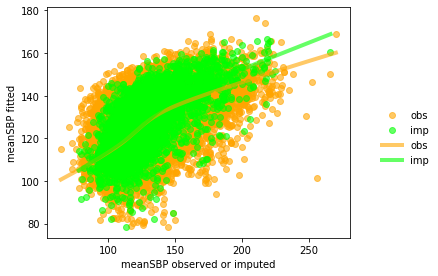

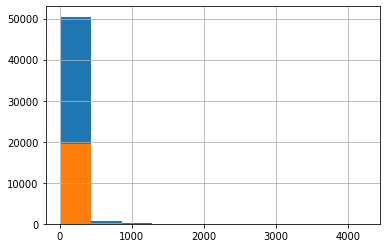

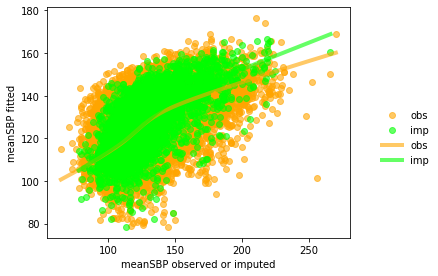

In [9]:

import statsmodels.imputation.mice as mice

def ols_formula(df, dependent_var):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    fml = ''
    for col in df_columns:
        fml = fml + ' + ' + col
    fml = fml + ' + year '
    return fml

imputedData = mice.MICEData(regressDF)
# have to leave LDL and trig out of each other's imputations...since their missingness is highly correlated
imputedData.set_imputer("ldl", formula='hdl + tot_chol + age + a1c + bmi + meanSBP + meanDBP + year')
imputedData.set_imputer("trig", formula='hdl + tot_chol + age + a1c + bmi + meanSBP + meanDBP + year')

for var in ['a1c', 'hdl', 'tot_chol', 'weight','bmi','meanSBP', 'meanDBP', 'waist', 'anyPhysicalActivity', 'alcoholPerWeek']:
    imputedData.set_imputer(var, formula=ols_formula(regressDF, var))

imputedData.update_all(20)

### Check missing data in imputed vs. baseline dataset...generally looks pretty good

regressDF.meanSBP.describe()

imputedData.data.meanSBP.describe()

%matplotlib inline
imputedData.data.trig.hist()
regressDF.trig.hist()

imputedData.plot_fit_obs("meanSBP")

### Export imputed dataset


In [10]:
# the imputation reset the time in US variable...we actally want the nulls there because they represent people
# that have been in the US their whole lives
imputedDataset = imputedData.data
imputedDataset.timeInUS = regressDF.timeInUS.values
imputedDataset['raceEthnicity'] = over18.raceEthnicity.values
imputedDataset['smokingStatus'] = over18.smokingStatus.values
imputedDataset['education'] = over18.education.values
imputedDataset['selfReportStrokeAge'] = over18.selfReportStrokeAge.values
imputedDataset['selfReportMIAge'] = over18.selfReportMIAge.values
imputedDataset.raceEthnicity.astype("int")
imputedDataset.drop(labels=['smokingStatus_0', 'smokingStatus_1','smokingStatus_2'],axis=1, inplace=True)
imputedDataset.drop(labels=['raceEthnicity_1', 'raceEthnicity_2','raceEthnicity_3', 'raceEthnicity_4','raceEthnicity_5' ],axis=1, inplace=True)
imputedDataset.drop(labels=['education_1', 'education_2', 'education_3', 'education_4', 'education_5'],axis=1, inplace=True)
imputedDataset.diedBy2011 = imputedDataset.diedBy2015.astype('int')

imputedDataset.to_csv("fullyImputedDataset.csv")
imputedDataset.to_stata("fullyImputedDataset.dta")
from shutil import copyfile

copyfile("fullyImputedDataset.dta", "/Users/burke/Documents/research/bpCog/mcm/mcm/data/fullyImputedDataset.dta")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/anaconda3/lib/python3.6/site-packages/pandas/io/stata.py:637: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column raceEthnicity contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  ValueLabelTypeMismatch)
/anaconda3/lib/python3.6/site-packages/pandas/io/stata.py:637: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column education contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  ValueLabelTypeMismatch)


'/Users/burke/Documents/research/bpCog/mcm/mcm/data/fullyImputedDataset.dta'